# Machine Learning for Social Media-Based Depression Analysis

## Business Understanding

Mental health is an urgent issue globally, with depression affecting millions of individuals across all demographics. The internet, and particularly social media, has become a place where people often express their struggles, including depression. Early detection of depression symptons can be crucial in providing timely support or intervention. This project’s goal is to leverage data science to better understand and detect depressive expressions in online platforms, potentially paving the way for more proactive mental health support. Given the widespread use of platforms like Reddit, this research could benefit individuals by increasing awareness and intervention opportunities


## Data Understanding

Datasource: https://www.kaggle.com/datasets/rishabhkausish/reddit-depression-dataset/data

The dataset already includes several key features that can be used to analyze and predict depression indicators based on Reddit posts. Specifically, the data has 7 key columns:

1. Subreddit : The subreddit where each post was made, with posts from "Depression" and "SuicideWatch" labeled as 1 for depression and posts from other subreddits labeled as 0 (non-depression).

2. Title: The title of the Reddit post.

3. Body: The full text of the Reddit post, which may contain valuable information for understanding the context, tone, and possible indicators of depression.

4. Upvotes: Number of upvotes each post received, which may indicate the post's visibility or resonance with the community.

5. Created_utc: The timestamp of when the post was created in UTC, which can help in analyzing temporal trends.

6. Num_comments: The number of comments on each post, which could provide insights into community engagement.

7. Label: The target variable indicating depression (1) or non-depression (0) based on subreddit. .... The raw data was collected from five Reddit subreddits (sub topics), categorized based on their content. These included: Teenagers, Depression, SuicideWatch, DeepThoughts, Happy

Since the data is already collected from Reddit, with over 6 million rows, further data acquisition may not be necessary. Infact, the team proposes reducing the dataset to about 500,000 rows for the purpose of this project(and to save our laptops). However, if additional data is needed, we could plan to scrape Reddit for more recent posts using a tool that we could identify through further research, provided we comply with Reddit's data collection policies and privacy standards.


In [6]:
#import libraries needed
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA


from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

In [7]:
#Load the dataset to use 
#data = pd.read_csv(file_path)  # 
data = pd.read_csv('Data/reduced_reddit.csv', index_col=False)
print(data.head(10))  # Display the first few rows of the dataframe


   subreddit                                              title  \
0  teenagers                        Day 18 of doing 50 push-ups   
1  teenagers  There isn’t a better feeling than finishing yo...   
2  teenagers  LMAOOO I can only get this guy to talk to me i...   
3  teenagers                       This isn't going to work out   
4  teenagers  Am I the only guy who found it hurtful as a ch...   
5  teenagers                                   Phew , close one   
6  teenagers              Listen to my favorite song part 2 🤩🤩🤩   
7  teenagers                                 Hard core cuddling   
8  teenagers                      Don't communicate with women.   
9  teenagers       Do you guys just ever want to be left alone?   

                                                body  upvotes   created_utc  \
0                                                NaN      4.0  1.619357e+09   
1  Then your teacher hits you with that “ Good jo...      7.0  1.554103e+09   
2                        

In [8]:
#check the dataset information 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98826 entries, 0 to 98825
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   subreddit     98826 non-null  object 
 1   title         98826 non-null  object 
 2   body          80371 non-null  object 
 3   upvotes       98826 non-null  float64
 4   created_utc   98826 non-null  float64
 5   num_comments  94297 non-null  float64
 6   label         98826 non-null  float64
dtypes: float64(4), object(3)
memory usage: 5.3+ MB


In [9]:
#check on the description of numerical datatypes
data.describe()

,upvotes,created_utc,num_comments,label
count,98826.000000,9.882600e+04,94297.000000,98826.000000
mean,62.315555,1.566569e+09,15.217069,0.194443
std,937.347581,6.977745e+07,71.638197,0.395773
min,4.000000,1.202084e+09,1.000000,0.000000
25%,5.000000,1.552254e+09,4.000000,0.000000
50%,7.000000,1.578218e+09,7.000000,0.000000
75%,11.000000,1.611584e+09,14.000000,0.000000
max,62899.000000,1.672531e+09,7880.000000,1.000000


## Data Cleaning

In [10]:
#check to see if there are null values in percentage form
data.isnull().sum() / len(data) * 100

subreddit        0.000000
title            0.000000
body            18.674236
upvotes          0.000000
created_utc      0.000000
num_comments     4.582802
label            0.000000
dtype: float64

The dataset has some columns that have null values, namely body and num_comments. The latter has 18% of the rows with missing values while the former has averagely 5% of missing values which we can drop these missing rows as it makes a small percentage of the data. 
For the body column, I will impute the missing values by filling with the  an empty string " ".  

In [11]:
# Now you can fill missing values in 'body' column 
data['num_comments'] = data['num_comments'].fillna(0)

# Check the DataFrame info again to confirm the change
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98826 entries, 0 to 98825
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   subreddit     98826 non-null  object 
 1   title         98826 non-null  object 
 2   body          80371 non-null  object 
 3   upvotes       98826 non-null  float64
 4   created_utc   98826 non-null  float64
 5   num_comments  98826 non-null  float64
 6   label         98826 non-null  float64
dtypes: float64(4), object(3)
memory usage: 5.3+ MB


In [12]:
data.isnull().sum()

subreddit           0
title               0
body            18455
upvotes             0
created_utc         0
num_comments        0
label               0
dtype: int64

In [13]:
# Check the DataFrame info again to confirm the change
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98826 entries, 0 to 98825
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   subreddit     98826 non-null  object 
 1   title         98826 non-null  object 
 2   body          80371 non-null  object 
 3   upvotes       98826 non-null  float64
 4   created_utc   98826 non-null  float64
 5   num_comments  98826 non-null  float64
 6   label         98826 non-null  float64
dtypes: float64(4), object(3)
memory usage: 5.3+ MB


In [14]:
# Now you can fill missing values in 'body' column 
data['body'] = data['body'].fillna(" ")

# Check the DataFrame info again to confirm the change
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98826 entries, 0 to 98825
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   subreddit     98826 non-null  object 
 1   title         98826 non-null  object 
 2   body          98826 non-null  object 
 3   upvotes       98826 non-null  float64
 4   created_utc   98826 non-null  float64
 5   num_comments  98826 non-null  float64
 6   label         98826 non-null  float64
dtypes: float64(4), object(3)
memory usage: 5.3+ MB


In [15]:
#check for missing values 
data.isnull().sum()

subreddit       0
title           0
body            0
upvotes         0
created_utc     0
num_comments    0
label           0
dtype: int64

In [16]:
# Convert 'created_utc' column from UTC epoch time to datetime
data['created_utc'] = pd.to_datetime(data['created_utc'], unit='s')


# Rename the column 'created_utc' to 'date'
data = data.rename(columns={'created_utc': 'date'})

# To see the updated DataFrame

data

,subreddit,title,body,upvotes,date,num_comments,label
0,teenagers,Day 18 of doing 50 push-ups,,4.0,2021-04-25 13:25:39,4.0,0.0
1,teenagers,There isn’t a better feeling than finishing yo...,Then your teacher hits you with that “ Good jo...,7.0,2019-04-01 07:19:57,0.0,0.0
2,teenagers,LMAOOO I can only get this guy to talk to me i...,Yeahhh maybe not babe,4.0,2022-04-07 14:35:00,12.0,0.0
3,teenagers,This isn't going to work out,,236.0,2014-12-03 18:12:52,33.0,0.0
4,teenagers,Am I the only guy who found it hurtful as a ch...,\n\nLike... why? How is that funny? How does ...,6.0,2019-09-23 23:07:59,4.0,0.0
...,...,...,...,...,...,...,...
98821,depression,Has anyone ever had any problems with gangs?,I don't care if my grammer isn't good so dont ...,8.0,2019-05-17 08:30:19,1.0,1.0
98822,SuicideWatch,"Moments away from killing myself, not even bot...","I don't want to talk about my problems, I don'...",12.0,2012-10-20 17:24:21,8.0,1.0
98823,SuicideWatch,I've grown used to being like this for years.,"I'm not suicidal at the moment, in fact I feel...",14.0,2015-05-19 22:19:26,4.0,1.0
98824,depression,This speech from The Lord of the Rings really ...,"""It's like in the great stories, Mr. Frodo. Th...",323.0,2012-12-16 15:44:18,28.0,1.0


## Exploratory Data Analysis

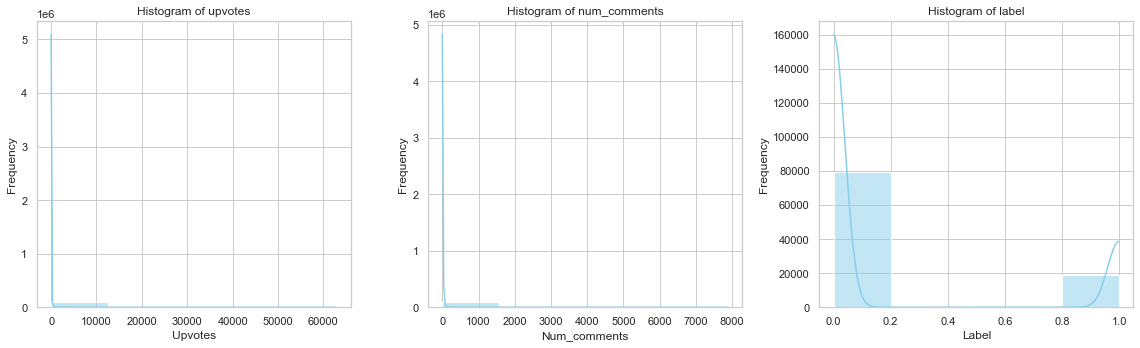

In [17]:
#Visualize the frequency distribution of values using histograms and to identify outliers using the box plots- for upvotes and num_comments

sns.set(style="whitegrid")
numeric_columns = ['upvotes', 'num_comments', 'label']

# Set up the subplot grid
fig, axes = plt.subplots(1, len(numeric_columns), figsize=(16, 5))

for i, col in enumerate(numeric_columns):
    sns.histplot(data[col], bins=5, kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col.capitalize())
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

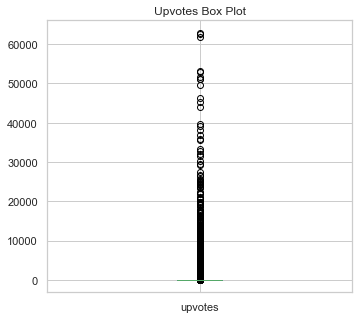

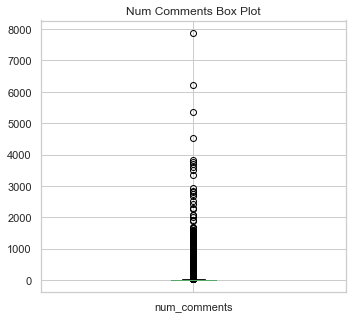

In [18]:
# Upvotes box plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
data['upvotes'].plot(kind='box')
plt.title('Upvotes Box Plot')
plt.show()

#for num_comments
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
data['num_comments'].plot(kind='box')
plt.title('Num Comments Box Plot')
plt.show()


teenagers       78251
depression      11672
SuicideWatch     7544
happy             995
DeepThoughts      364
Name: subreddit, dtype: int64
0.0    79610
1.0    19216
Name: label, dtype: int64


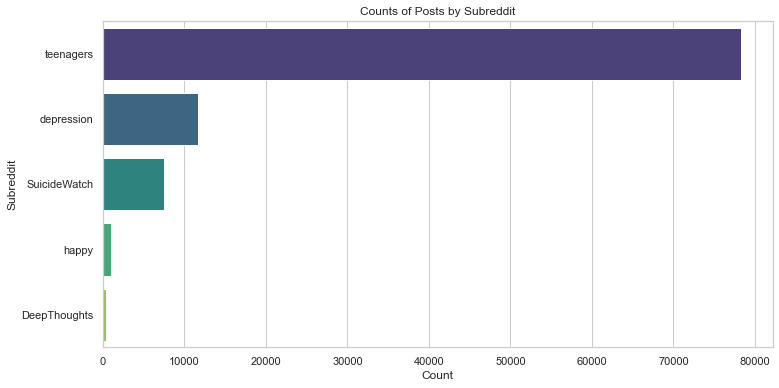

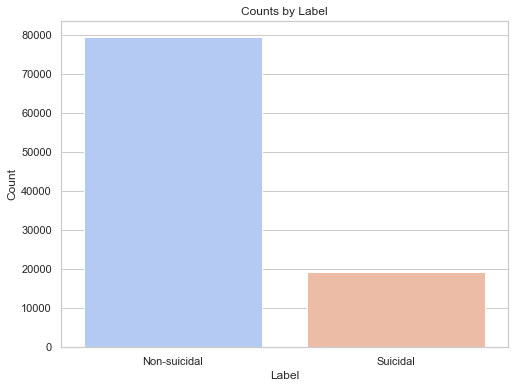

In [19]:
#Frequency of categorical columns

# Frequency of 'subreddit' column
print(data['subreddit'].value_counts())

# Frequency of 'label' column
print(data['label'].value_counts())

# Set style
sns.set(style="whitegrid")

# Plot the counts for 'subreddit' column
plt.figure(figsize=(12, 6))
sns.countplot(data=data, y='subreddit', order=data['subreddit'].value_counts().index, palette='viridis')
plt.title('Counts of Posts by Subreddit')
plt.xlabel('Count')
plt.ylabel('Subreddit')
plt.show()

# Plot the counts for 'label' column
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='label', palette='coolwarm')
plt.title('Counts by Label')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Non-suicidal', 'Suicidal'])
plt.show()


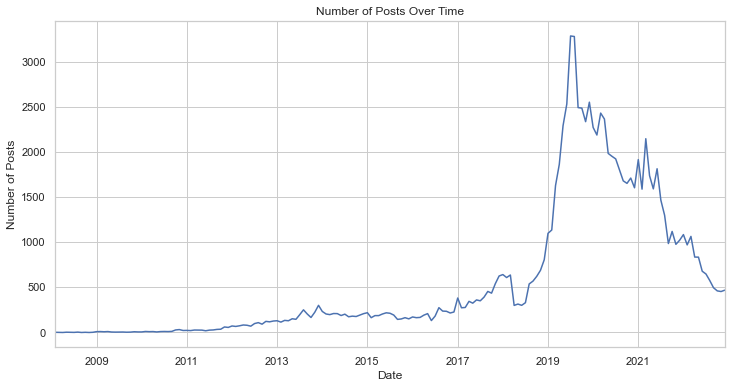

In [20]:
# Plot number of posts over time

data.set_index('date', inplace=True)

# Plot number of posts per month
data.resample('M').size().plot(figsize=(12, 6))
plt.title('Number of Posts Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.show()

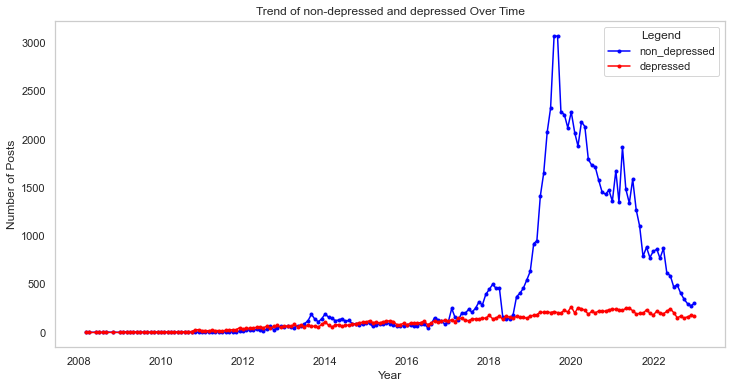

In [21]:
# Resample the data by month (change this to 'W' for weekly or 'D' for daily)
label_trend = data.resample('M')['label'].value_counts().unstack().fillna(0)

# Plot the trend over time for both labels
plt.figure(figsize=(12, 6))
plt.plot(label_trend.index, label_trend[0], label='non_depressed', color='blue', marker='.')
plt.plot(label_trend.index, label_trend[1], label='depressed', color='red', marker='.')

# Adding titles and labels
plt.title('Trend of non-depressed and depressed Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Posts')
plt.legend(title='Legend')
plt.grid(False)

# Show the plot
plt.show()

## Bivariate Analysis

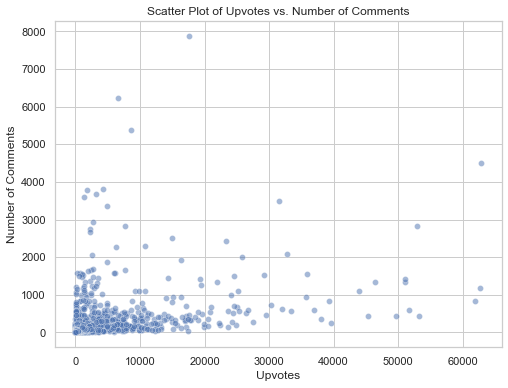

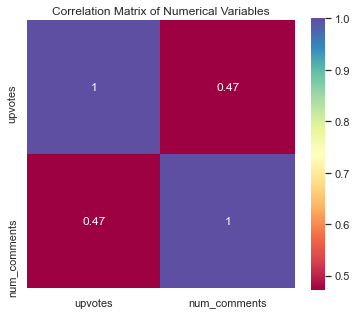

In [22]:
#Numerical vs. Numerical (Scatter plot and correlation matrix)
#Scatter Plot - Shows the relationship between two numerical variables, upvotes and num_comments.

# Scatter plot for numerical variables
plt.figure(figsize=(8, 6))
sns.scatterplot(x='upvotes', y='num_comments', data=data, alpha=0.5)
plt.title("Scatter Plot of Upvotes vs. Number of Comments")
plt.xlabel("Upvotes")
plt.ylabel("Number of Comments")
plt.show()

# Correlation matrix and heatmap
correlation_matrix = data[['upvotes', 'num_comments']].corr()
plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='Spectral', square=True)
plt.title("Correlation Matrix of Numerical Variables")
plt.show()

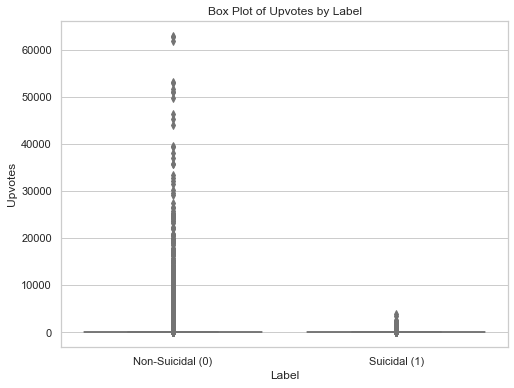

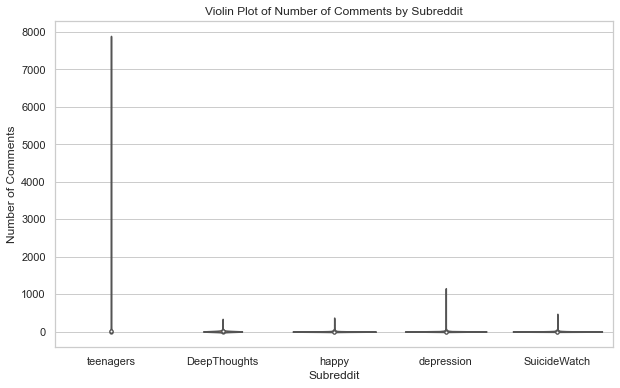

In [23]:
# Numerical vs. Categorical (Box plot and Violin plot)
# Box plot of 'upvotes' by 'label'
plt.figure(figsize=(8, 6))
sns.boxplot(x='label', y='upvotes', data=data, palette='pastel')
plt.title("Box Plot of Upvotes by Label")
plt.xlabel("Label")
plt.ylabel("Upvotes")
plt.xticks(ticks=[0, 1], labels=["Non-Suicidal (0)", "Suicidal (1)"])
plt.show()

# Violin plot of 'num_comments' by 'subreddit'
plt.figure(figsize=(10, 6))
sns.violinplot(x='subreddit', y='num_comments', data=data, palette='muted')
plt.title("Violin Plot of Number of Comments by Subreddit")
plt.xlabel("Subreddit")
plt.ylabel("Number of Comments")
plt.show()

Crosstab of Subreddit by Label:
label           0.0    1.0
subreddit                 
DeepThoughts    364      0
SuicideWatch      0   7544
depression        0  11672
happy           995      0
teenagers     78251      0


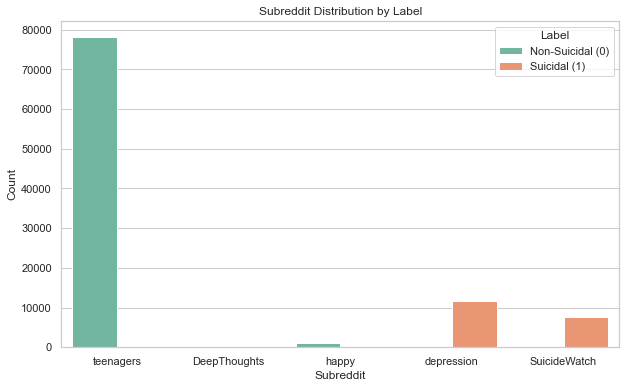

In [24]:
# Crosstab between 'subreddit' and 'label'
crosstab = pd.crosstab(data['subreddit'], data['label'])
print("Crosstab of Subreddit by Label:")
print(crosstab)

# Bar plot for 'subreddit' and 'label'
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x="subreddit", hue="label", palette="Set2")
plt.title("Subreddit Distribution by Label")
plt.xlabel("Subreddit")
plt.ylabel("Count")
plt.legend(title="Label", loc='upper right', labels=["Non-Suicidal (0)", "Suicidal (1)"])
plt.show()

## Multivariate Analysis

In [25]:
# Pair plot with 'label' as the hue
sns.pairplot(data[['upvotes', 'num_comments', 'date', 'label']], hue='label', palette='Set1', diag_kind='kde')
plt.suptitle("Pair Plot of Numerical Variables by Label", y=1.02)
plt.show()

KeyError: "['date'] not in index"

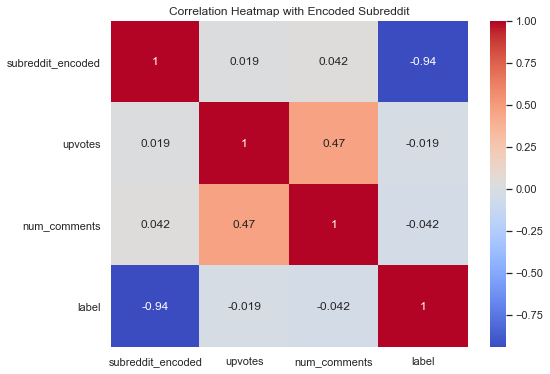

In [ ]:
# Convert the 'subreddit' column to numeric using label encoding
data['subreddit_encoded'] = LabelEncoder().fit_transform(data['subreddit'])

# Now include the encoded 'subreddit' in the heatmap
plt.figure(figsize=(8,6))
sns.heatmap(data[['subreddit_encoded', 'upvotes', 'num_comments', 'label']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap with Encoded Subreddit')
plt.show()

In [ ]:

# --- 1. Feature Creation ---

# Extract year, month, day, hour from 'date'
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['hour'] = data['date'].dt.hour

# Create additional features like ratios or flags
data['upvotes_per_comment'] = data['upvotes'] / (data['num_comments'] + 1)  # Adding 1 to avoid division by zero
data['has_body'] = data['body'].apply(lambda x: 0 if x == ' ' else 1)  # Flag indicating if there's content in 'body'


# --- 2. Scaling and Normalization ---
# Initialize scalers
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

# Apply Standard Scaling on numerical features
data[['upvotes', 'num_comments', 'upvotes_per_comment']] = standard_scaler.fit_transform(
    data[['upvotes', 'num_comments', 'upvotes_per_comment']]
)

# Apply Min-Max Scaling on year, month, day, hour (optional)
data[['year', 'month', 'day', 'hour']] = minmax_scaler.fit_transform(
    data[['year', 'month', 'day', 'hour']]
)

# --- 3. Drop the subreddit column ---

data = data.drop(columns=['subreddit'])


# Display the final DataFrame
print(data)



                                                   title  \
0                            Day 18 of doing 50 push-ups   
1      There isn’t a better feeling than finishing yo...   
2      LMAOOO I can only get this guy to talk to me i...   
3                           This isn't going to work out   
4      Am I the only guy who found it hurtful as a ch...   
...                                                  ...   
98821       Has anyone ever had any problems with gangs?   
98822  Moments away from killing myself, not even bot...   
98823      I've grown used to being like this for years.   
98824  This speech from The Lord of the Rings really ...   
98825                              I just don't know....   

                                                    body   upvotes  \
0                                                        -0.062214   
1      Then your teacher hits you with that “ Good jo... -0.059013   
2                                  Yeahhh maybe not babe -0.062214   

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98826 entries, 0 to 98825
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   title                98826 non-null  object        
 1   body                 98826 non-null  object        
 2   upvotes              98826 non-null  float64       
 3   date                 98826 non-null  datetime64[ns]
 4   num_comments         98826 non-null  float64       
 5   label                98826 non-null  float64       
 6   year                 98826 non-null  float64       
 7   month                98826 non-null  float64       
 8   day                  98826 non-null  float64       
 9   hour                 98826 non-null  float64       
 10  upvotes_per_comment  98826 non-null  float64       
 11  has_body             98826 non-null  int64         
dtypes: datetime64[ns](1), float64(8), int64(1), object(2)
memory usage: 9.0+ MB


## Natural Language Preprocessing

In [ ]:
#Text Preprocessing 

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.base import TransformerMixin, BaseEstimator
import string

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Initialize stopwords, punctuation, and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

#define a class TextPreprocessor that conforms to scikit-learn’s transformer API
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self  # No fitting required for this transformer

    def transform(self, X, y=None):
        return X.apply(self._preprocess_text)

    def _preprocess_text(self, text):
        if pd.isnull(text):
            return ''  # Return empty string for missing values
        text = text.lower()  # Lowercase
        text = ''.join([char for char in text if char not in string.punctuation])  # Remove punctuation
        tokens = word_tokenize(text)  # Tokenize
        tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
        tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatize
        return ' '.join(tokens)  # Join tokens back into string


# Instantiate TextPreprocessor
text_preprocessor = TextPreprocessor()

# Apply the text preprocessor to 'title' and 'body' columns
data['processed_title'] = text_preprocessor.transform(data['title'])
data['processed_body'] = text_preprocessor.transform(data['body'])

# Display the processed data
data[['processed_title', 'processed_body']]


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\GICHEHA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\GICHEHA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\GICHEHA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,processed_title,processed_body
0,day 18 50 pushup,
1,’ better feeling finishing science paper 1am d...,teacher hit “ good job everyone draft final co...
2,lmaooo get guy talk talk god💖💖,yeahhh maybe babe
3,isnt going work,
4,guy found hurtful child movie kid female chara...,like funny deserve better male character kick ...
...,...,...
98821,anyone ever problem gang,dont care grammer isnt good dont even bring se...
98822,moment away killing even bothering make throw ...,dont want talk problem dont want talk problem ...
98823,ive grown used like year,im suicidal moment fact feel great right time ...
98824,speech lord ring really inspires go,like great story mr frodo one really mattered ...


We will produce  numerical representation of the text data, enabling us to use it as input for machine learning models.

We will use TF-IDF as it weighs words by their frequency in a document relative to their frequency across all documents.

It allows to leverage the importance of unique words within each post and balances the contribution of frequent words, making it well-suited for distinguishing between subreddits or post types.

starting with TF-IDF and evaluate its performance. If the results aren’t satisfactory, we will consider experimenting with word embeddings for potential improvements.

In [ ]:
# TF-IDF -give higher weights to words that are less common across documents.
# Import necessary libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix


# Apply TF-IDF to the title and body columns separately
tfidf_vectorizer = TfidfVectorizer(max_features=10000)  # limit to top 10,000 features_to manage vocabulary size


# Use the processed title and body columns 
tfidf_title = tfidf_vectorizer.fit_transform(data['processed_title'])
tfidf_body = tfidf_vectorizer.fit_transform(data['processed_body'])

# You can keep these as sparse matrices or concatenate directly if needed for model input
combined_features = csr_matrix(tfidf_title) + csr_matrix(tfidf_body) # in sparse format, to save memory

Here we have feature reduction where I will be working with the top 10,000 - retaining the most relevant words, reducing noise and memory load.

If I use all features, I get a memory error indicating that the conversion of the TF-IDF sparse matrix to a dense format (.toarray()) is exceeding your available memory, likely due to the large number of documents and vocabulary size.

Hence the Sparse Matrix Size: The resulting TF-IDF matrix will have a maximum of 10,000 columns (features), significantly reducing memory requirements when compared to the full vocabulary size.

This compromise allows us to handle large datasets while retaining a high level of detail in the features for training your model.

#### EDA ON THE PROCESSED TEXT DATA

In [ ]:
#Examine the top words by TF-IDF Scores

# Display the top terms with the highest TF-IDF scores
tfidf_sum = combined_features.sum(axis=0)
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame({'term': feature_names, 'tfidf_score': tfidf_sum.A1})
tfidf_df = tfidf_df.sort_values(by='tfidf_score', ascending=False)

# Display the top 20 terms with the highest TF-IDF scores
tfidf_df.head(20)

,term,tfidf_score
4558,im,2951.154806
9640,want,2920.344788
5264,like,2674.925609
4540,ie,1887.889586
2835,dont,1867.329365
5082,know,1829.199974
3500,feel,1785.575874
3924,get,1679.820679
6165,one,1572.184302
5247,life,1482.131980


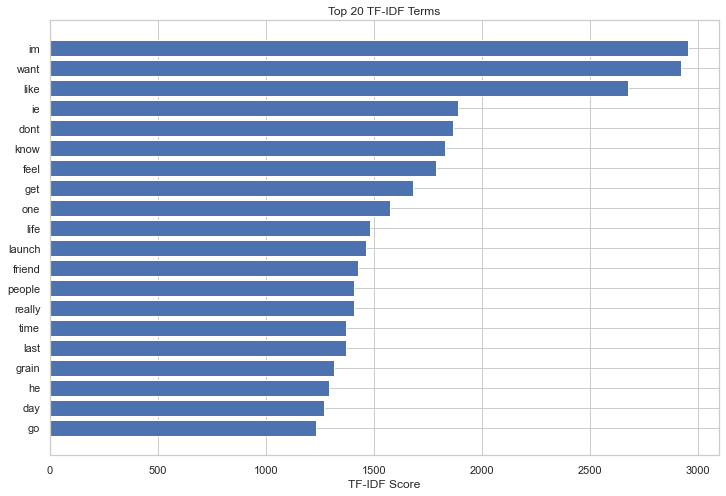

In [ ]:
# Visualize the Top TF-IDF Terms

# Bar plot of the top 20 terms
plt.figure(figsize=(12, 8))
plt.barh(tfidf_df['term'].head(20), tfidf_df['tfidf_score'].head(20))
plt.xlabel("TF-IDF Score")
plt.title("Top 20 TF-IDF Terms")
plt.gca().invert_yaxis()
plt.show()

## Model Selection and Training

In [ ]:
#Select and train a model using features extracted in the previous step.
# Model 1 - Baseline Model 
#Logistic Regression from sklearn.model_selection import train_test_split

from imblearn.pipeline import Pipeline as ImbPipeline  # Use imbalanced-learn's Pipeline for compatibility with SMOTE
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


# Combine the title and body text into one column
data['combined_text'] = data['title'].fillna('') + ' ' + data['body'].fillna('')

# Define the target and features
X = data[['combined_text']]
y = data['label']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing: text vectorization only
preprocessor = ColumnTransformer([
    ('text', TfidfVectorizer(max_features=10000), 'combined_text')  # Text processing
])

# Define a pipeline with preprocessing, SMOTE, and logistic regression
pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(solver='saga', max_iter=200))
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Evaluate on training data
train_predictions = pipeline.predict(X_train)
train_accuracy = accuracy_score(y_train, train_predictions)
print("Training Accuracy:", train_accuracy)

# Evaluate on testing data
test_predictions = pipeline.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
print("Testing Accuracy:", test_accuracy)

# Print classification report for test set
print("Classification Report:\n", classification_report(y_test, test_predictions))



Training Accuracy: 0.9278016696180116
Testing Accuracy: 0.9182434483456441
Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.92      0.95     15998
         1.0       0.73      0.91      0.81      3768

    accuracy                           0.92     19766
   macro avg       0.85      0.91      0.88     19766
weighted avg       0.93      0.92      0.92     19766



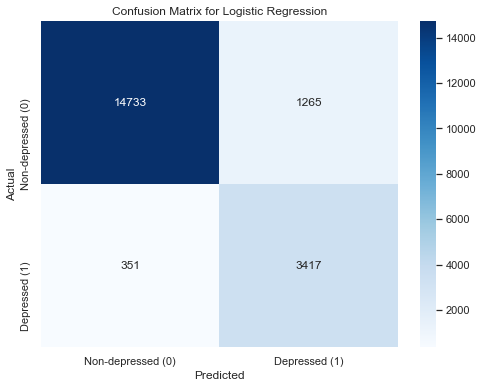

In [ ]:
from sklearn.metrics import confusion_matrix


# Predictions on the test set
test_predictions = pipeline.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, test_predictions)

# Visualize the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-depressed (0)', 'Depressed (1)'], 
            yticklabels=['Non-depressed (0)', 'Depressed (1)'])
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


#### Evaluation of theBbaseline Model - Logistic Regression

Class 0 (Non-depressed): With a precision of 0.98, the model rarely mislabels non-depressed posts. The recall of 0.92 indicates that most non-depressed posts are correctly identified.

Class 1 (Depressed): Precision is 0.73, which shows that when the model predicts "depressed," it’s correct 73% of the time. The recall is 0.91, meaning the model successfully identifies 91% of depressed posts.

Overall:

The f1-score for both classes indicates a good balance between precision and recall, especially for Class 1, which can be challenging due to imbalance.

Macro avg and weighted avg scores reflect the model's generalization, with an overall accuracy of 92%.


### Tuning and Optimization Hyperparameter Tuning - Randomized search CV.

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from scipy.stats import uniform, randint


# Sample dataset (replace with your own dataset)
X = np.random.rand(1000, 10)  # Example feature matrix
y = np.random.randint(0, 2, size=1000)  # Example binary target

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define a pipeline with a StandardScaler and LightGBM model
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Optional: Scaling features
    ('lgb', lgb.LGBMClassifier())
])

# Define the hyperparameter space for RandomizedSearchCV
param_grid = {
    'lgb__n_estimators': [200, 250, 300],
    'lgb__learning_rate': [0.01, 0.05, 0.1],
    'lgb__max_depth': [4, 6, 8],
    'lgb__num_leaves': [50, 100, 150],
    'lgb__bagging_fraction': [0.7, 0.8, 0.9],
    'lgb__feature_fraction': [0.7, 0.8, 0.9],
    'lgb__lambda_l1': [0, 0.1, 0.5],
    'lgb__lambda_l2': [0, 0.1, 0.5],
    'lgb__early_stopping_rounds': [50]
}

# Instantiate the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    pipeline, param_distributions=param_dist, 
    n_iter=50, cv=5, n_jobs=-1, verbose=2, random_state=42
)

# Fit the model
random_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation score: ", random_search.best_score_)

# Evaluate on the test set
test_score = random_search.score(X_test, y_test)
print("Test score: ", test_score)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Warning] feature_fraction is set=0.88453678109946, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.88453678109946
[LightGBM] [Warning] bagging_fraction is set=0.679536961635522, subsample=1.0 will be ignored. Current value: bagging_fraction=0.679536961635522
[LightGBM] [Warning] feature_fraction is set=0.88453678109946, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.88453678109946
[LightGBM] [Warning] bagging_fraction is set=0.679536961635522, subsample=1.0 will be ignored. Current value: bagging_fraction=0.679536961635522
[LightGBM] [Info] Number of positive: 355, number of negative: 345
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2337
[LightGBM] [Info] Number of data points in the train set: 700, number of used feature

Best Parameters:

Bagging Fraction: 0.68

Feature Fraction: 0.88

Learning Rate: 0.17

Max Depth: 7

Min Child Samples: 14

Number of Estimators: 90

Number of Leaves: 58

Cross-Validation Score:

0.523, which is a moderate result.

Test Score:

0.467, indicating that the model’s generalization to unseen data can be improved.

In [ ]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Split data (example)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Ensure the input data is a series of strings
X_train = X_train.astype(str)

# Define the pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=1000)),
    ('lgb', LGBMClassifier())
])

# Define the hyperparameter grid
param_grid = {
    'tfidf__max_features': [500, 1000],  # Limit to a small grid for fewer fits
    'lgb__num_leaves': [31, 50],
    'lgb__learning_rate': [0.05, 0.1],
    'lgb__n_estimators': [50, 100]
}

# Setup GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,  # Reduce the number of cross-validation splits
    n_jobs=-1,  # Use all available CPU cores
    verbose=1,  # Show progress
    scoring='accuracy'  # Use the appropriate scoring metric
)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Output the best hyperparameters
print(f"Best hyperparameters: {grid_search.best_params_}")


Fitting 3 folds for each of 16 candidates, totalling 48 fits


c:\Users\GICHEHA\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
48 fits failed out of a total of 48.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
48 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\GICHEHA\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\GICHEHA\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\GICHEHA\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 348, in _fit
    X, fitted_tr

AttributeError: 'numpy.ndarray' object has no attribute 'lower'